In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

# Regression

Z = severity of symptoms

X = dosage of medication given

Y = recovery time

### Note: this error term has nonzero mean!  This is a problem of definition.
### Also, the error term is uniform, not normal, which is not quite what we hope for, but it'll be okay.

In [3]:
np.random.seed(0)
numrows = 1000
Z_severity = np.clip(np.random.normal(5, 2, (numrows,)), 0, 10)
X_dosage = Z_severity + np.random.uniform(0, 10, (numrows,))
Y_recovery = np.maximum(2 * Z_severity - 0.5 * X_dosage + np.random.uniform(0, 10, (numrows,)), 0)
df = pd.DataFrame({"X": X_dosage, "Y": Y_recovery, "Z": Z_severity})

In [126]:
np.random.seed(0)
numrows = 10000
Z_severity = np.clip(np.random.normal(5, 2, (numrows,)), 0, 10)
X_dosage = Z_severity + np.random.uniform(0, 10, (numrows,))
Y_recovery = np.maximum(5 + 2 * Z_severity - 0.5 * X_dosage + np.random.uniform(-5, 5, (numrows,)), 0)
df = pd.DataFrame({"X": X_dosage, "Y": Y_recovery, "Z": Z_severity})

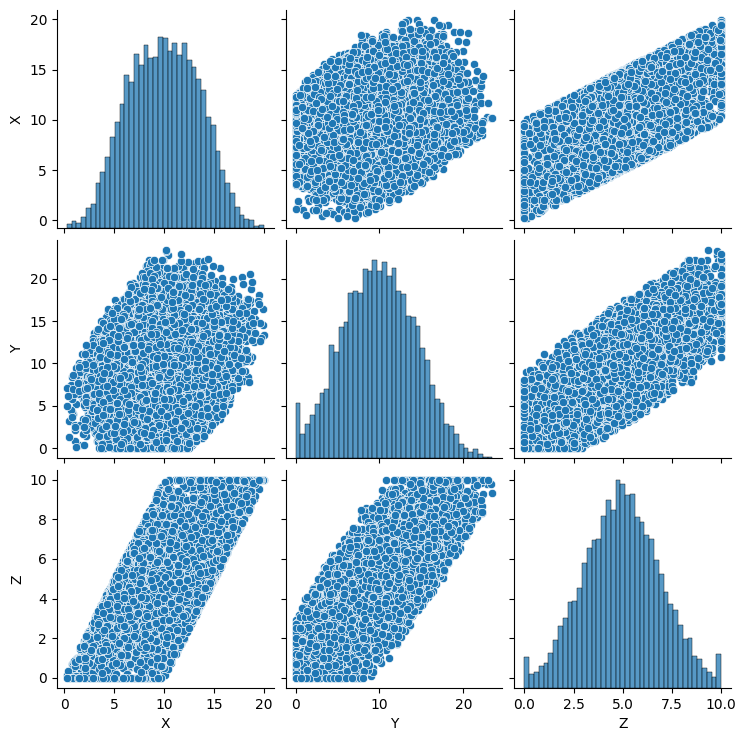

In [127]:
sns.pairplot(df)

### Doesn't quite work - confounder (Z) changes X coefficient

In [128]:
results = sm.OLS(df.Y, sm.add_constant(df[["X"]])).fit()
results.params

const    8.775363
X        0.116826
dtype: float64

In [129]:
results = sm.OLS(df.Y, sm.add_constant(df[["X"]])).fit()
results.params

const    8.775363
X        0.116826
dtype: float64

### Works - controlling for the confounder (Z) makes the coefficients correct

In [130]:
results = sm.OLS(df.Y, sm.add_constant(df[["X", "Z"]])).fit()
results.params

const    5.056672
X       -0.500548
Z        1.988107
dtype: float64

In [131]:
results.bse

const    0.092436
X        0.009847
Z        0.017696
dtype: float64

### Make X and Z more closely related

In [138]:
numrows = 1000000
np.random.seed(1)
Z_severity = np.minimum(np.maximum(np.random.normal(5, 2, (numrows,)), 0), 10)
X_dosage = Z_severity + np.random.uniform(0, 0.5, (numrows,))
Y_recovery = np.maximum(5 + 2 * Z_severity - 0.5 * X_dosage + np.random.uniform(-5, 5, (numrows,)), 0)
df2 = pd.DataFrame({"X": X_dosage, "Y": Y_recovery, "Z": Z_severity})

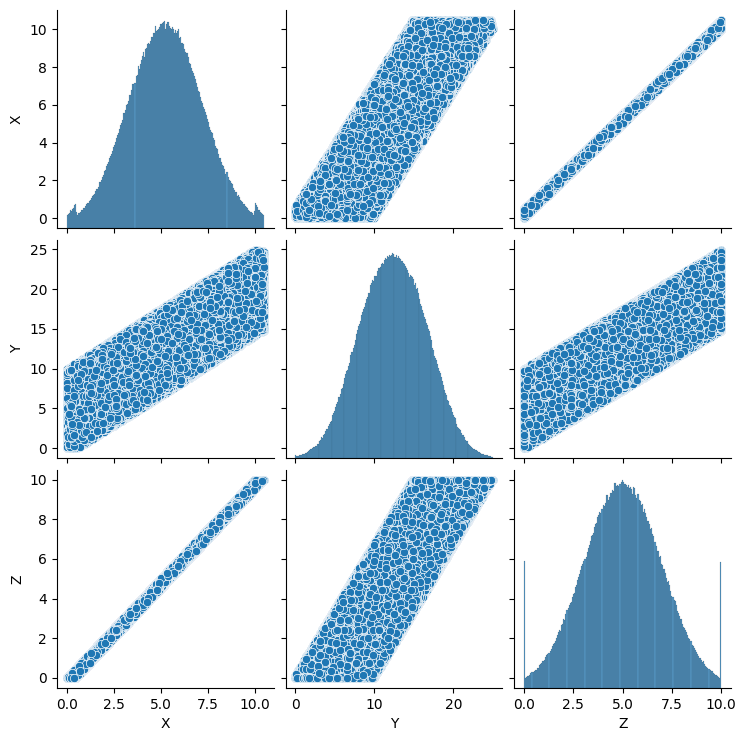

In [139]:
sns.pairplot(df2)

### Doesn't work - confounder changes X coefficient

In [140]:
results = sm.OLS(df2.Y, sm.add_constant(df2[["X"]])).fit()
results.params

const    4.549738
X        1.490323
dtype: float64

### Also doesn't work - X and Z are too highly correlated for regression to work.

In [141]:
results = sm.OLS(df2.Y, sm.add_constant(df2[["X", "Z"]])).fit()
results.params

const    4.996545
X       -0.516983
Z        2.018288
dtype: float64

In [133]:
np.corrcoef(df2.X, df2.Z)[0,1]

0.9973382861800948

### Again, be sure to include intercept here

In [143]:
variance_inflation_factor(sm.add_constant(df2[["X", "Z"]]), 2)

188.39920744371645

### What happens if Z is not a confounder?

In [144]:
np.random.seed(0)
numrows = 10000
Z_severity = np.minimum(np.maximum(np.random.normal(5, 2, (numrows,)), 0), 10)
X_dosage = np.random.uniform(0, 10, (numrows,))
Y_recovery = np.maximum(5 + 2 * Z_severity - 0.5 * X_dosage + np.random.uniform(-5, 5, (numrows,)), 0)
df3 = pd.DataFrame({"X": X_dosage, "Y": Y_recovery, "Z": Z_severity})

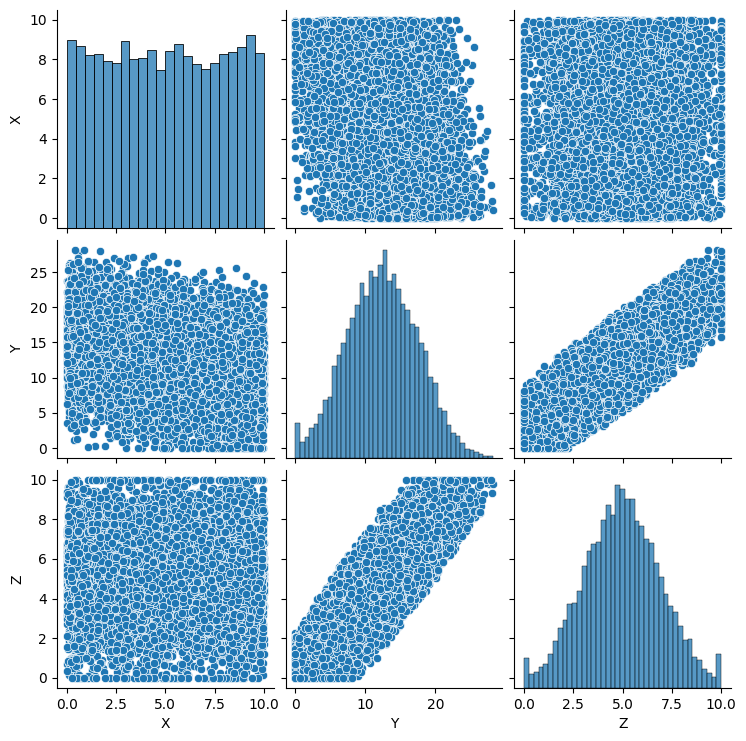

In [145]:
sns.pairplot(df3)

### This works!  X coefficient ~-0.5

In [146]:
results = sm.OLS(df3.Y, sm.add_constant(df3[["X"]])).fit()
results.params

const    14.912259
X        -0.499406
dtype: float64

In [147]:
results.bse

const    0.096022
X        0.016596
dtype: float64

In [148]:
results = sm.OLS(df3.Y, sm.add_constant(df3[["X", "Z"]])).fit()
results.params

const    5.045667
X       -0.501896
Z        1.990481
dtype: float64

In [149]:
results.bse

const    0.092557
X        0.009860
Z        0.014704
dtype: float64

# Matching

In [161]:
numrows = 10
np.random.seed(2)
Z_severity = np.minimum(np.maximum(np.random.normal(5, 2, (numrows,)), 0), 10)
X_dosage = np.random.binomial(1, Z_severity / 10, (numrows,))
Y_recovery = np.maximum(5 + 2 * Z_severity - 2.5 * X_dosage + np.random.uniform(-5, 5, (numrows,)), 0)
df_match = pd.DataFrame({"X": X_dosage, "Y": Y_recovery, "Z": Z_severity})

In [162]:
treated = df_match[df_match["X"] == 1]
control = df_match[df_match["X"] == 0]
model = NearestNeighbors(n_neighbors = 1)
result = model.fit(control[["Z"]])

In [168]:
result.kneighbors(np.array([[3], [4]]))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


(array([[0.18198477],
        [0.81801523]]),
 array([[4],
        [4]]))

In [163]:
control

,X,Y,Z
2,0,5.736439,0.727608
4,0,4.097857,1.413129
6,0,14.271646,6.005763
7,0,6.088304,2.509424
9,0,9.862232,3.181985


In [ ]:
results.kneighbors

In [169]:
prediction = result.kneighbors(treated[["Z"]])

In [170]:
pd.DataFrame(treated.Z).reset_index()

,index,Z
0,0,4.166484
1,1,4.887466
2,3,8.280542
3,5,3.316505
4,8,2.884096


In [171]:
pd.DataFrame(control.Z).reset_index()

,index,Z
0,2,0.727608
1,4,1.413129
2,6,6.005763
3,7,2.509424
4,9,3.181985


In [172]:
prediction[0]

array([[0.98449954],
       [1.11829649],
       [2.27477878],
       [0.1345205 ],
       [0.29788921]])

In [173]:
prediction[1]

array([[4],
       [2],
       [2],
       [4],
       [4]])

In [175]:
prediction[1].flatten()

array([4, 2, 2, 4, 4])

In [84]:
matched_controls = control.iloc[prediction[1].flatten()]
matched_controls

,X,Y,Z
9,0,9.862232,3.181985
6,0,14.271646,6.005763
6,0,14.271646,6.005763
9,0,9.862232,3.181985
9,0,9.862232,3.181985


In [187]:
numrows = 1000
np.random.seed(0)
Z_severity = np.minimum(np.maximum(np.random.normal(5, 2, (numrows,)), 0), 10)
X_dosage = np.random.binomial(1, Z_severity / 10, (numrows,))
Y_recovery = np.maximum(5 + 2 * Z_severity - 2.5 * X_dosage + np.random.uniform(-5, 5, (numrows,)), 0)
df_match = pd.DataFrame({"X": X_dosage, "Y": Y_recovery, "Z": Z_severity})
treated = df_match[df_match["X"] == 1]
control = df_match[df_match["X"] == 0]

In [188]:
model = NearestNeighbors(n_neighbors = 1)
result = model.fit(control[["Z"]])

In [189]:
prediction = result.kneighbors(treated[["Z"]])
matched_controls = control.iloc[prediction[1].flatten()]

## The effect

In [190]:
treated.Y.mean() - matched_controls.Y.mean()

-2.2573422793951856

In [191]:
model = NearestNeighbors(n_neighbors = 1)
result = model.fit(treated[["Z"]])
prediction = result.kneighbors(control[["Z"]])
matched_treated = treated.iloc[prediction[1].flatten()]
matched_treated.Y.mean() - control.Y.mean()

-2.3513862087024187

In [192]:
model = NearestNeighbors(n_neighbors = 1, radius = 0.5)
result = model.fit(control[["Z"]])
prediction = result.radius_neighbors(treated[["Z"]])
prediction[1]

array([array([161, 335, 269,  61, 207]), array([161, 335, 269,  61, 207]),
       array([333,  85, 347, 185, 381, 288, 137, 175, 196, 103, 511,  65, 214,
               32, 314, 263, 307, 233,  58, 403, 180, 304, 478,  99,  82,  83,
              123, 427, 398, 465, 156, 236,  52,  24,  91, 257, 204,  87, 197,
              402, 242, 110, 493, 230, 468, 114, 353, 322, 395, 426, 354, 319,
              363, 270, 342, 366,  30, 174, 272, 274, 470,  19, 394, 251, 464,
               45, 503, 425, 466, 473,  10, 477, 429,  81, 495, 221, 130,  38,
              172,  92, 471, 379, 390, 245, 488, 235, 382,  69, 404, 187, 469,
              297,  60, 449,  80,  13, 101, 299])                             ,
       array([124, 308,   7,  63, 231,  28, 407, 178, 371, 506, 179, 303, 414,
              218,  86, 255, 237, 212,  12, 330, 409, 265, 107, 275, 482,   1,
              367, 151, 253, 346, 166, 358, 157,  78, 370, 291, 462, 383])    ,
       array([458, 508, 334, 392, 350, 234, 500, 364, 

In [194]:
treated.head()

,X,Y,Z
0,1,24.366003,8.528105
4,1,19.757958,8.735116
5,1,6.030297,3.045444
6,1,18.521861,6.900177
9,1,17.596129,5.821197


In [193]:
control.iloc[[161, 335, 269,  61, 207]]

,X,Y,Z
301,0,21.186887,8.316261
627,0,24.783811,8.341886
519,0,18.949397,8.485338
113,0,22.267872,8.820130
388,0,23.976564,8.296270


In [60]:
control.query("(Z > 8.028105) & (Z < 9.028105)")

,X,Y,Z
113,0,22.267872,8.820130
301,0,21.186887,8.316261
388,0,23.976564,8.296270
519,0,18.949397,8.485338
627,0,24.783811,8.341886


In [111]:
treated

,X,Y,Z
0,1,24.366003,8.528105
4,1,19.757958,8.735116
5,1,6.030297,3.045444
6,1,18.521861,6.900177
9,1,17.596129,5.821197
...,...,...,...
990,1,15.450539,5.882066
992,1,11.126606,3.401155
993,1,16.146761,5.481575
995,1,14.743577,5.825742


In [120]:
# Count duplicates
(pd.Series([y for x in prediction[1] for y in x]).value_counts() - 1).sum()

32383

In [197]:
[y for x in prediction[1] for y in x]

[161,
 335,
 269,
 61,
 207,
 161,
 335,
 269,
 61,
 207,
 333,
 85,
 347,
 185,
 381,
 288,
 137,
 175,
 196,
 103,
 511,
 65,
 214,
 32,
 314,
 263,
 307,
 233,
 58,
 403,
 180,
 304,
 478,
 99,
 82,
 83,
 123,
 427,
 398,
 465,
 156,
 236,
 52,
 24,
 91,
 257,
 204,
 87,
 197,
 402,
 242,
 110,
 493,
 230,
 468,
 114,
 353,
 322,
 395,
 426,
 354,
 319,
 363,
 270,
 342,
 366,
 30,
 174,
 272,
 274,
 470,
 19,
 394,
 251,
 464,
 45,
 503,
 425,
 466,
 473,
 10,
 477,
 429,
 81,
 495,
 221,
 130,
 38,
 172,
 92,
 471,
 379,
 390,
 245,
 488,
 235,
 382,
 69,
 404,
 187,
 469,
 297,
 60,
 449,
 80,
 13,
 101,
 299,
 124,
 308,
 7,
 63,
 231,
 28,
 407,
 178,
 371,
 506,
 179,
 303,
 414,
 218,
 86,
 255,
 237,
 212,
 12,
 330,
 409,
 265,
 107,
 275,
 482,
 1,
 367,
 151,
 253,
 346,
 166,
 358,
 157,
 78,
 370,
 291,
 462,
 383,
 458,
 508,
 334,
 392,
 350,
 234,
 500,
 364,
 287,
 141,
 385,
 460,
 117,
 323,
 273,
 494,
 343,
 173,
 102,
 229,
 239,
 153,
 315,
 8,
 89,
 446,
 90,